In [1]:
import pandas as pd
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import argparse
import pickle
from tqdm import tqdm
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

In [2]:
test_data = pd.read_csv('alsfrs_test.csv', index_col=0)

In [3]:
class CTHMM:
    def __init__(self, n_states, n_dim):
        self.n_states = n_states
        self.log_pi = np.log(np.ones((self.n_states)) / self.n_states)
        self.log_P = {}
        self.n_pid = 0
        self.log_likelihoods = None
        
        # init R
        self.R = -np.eye(self.n_states)
        self.R[-1, -1] = 0
        for i in range(self.n_states - 1):
            self.R[i,i+1:] = 1 / (self.R[i+1:].shape[0])
        
        self.n_dim = n_dim
        
        # init emission matrix
        self.emission_matrix = np.zeros((2, self.n_states, self.n_dim))
        self.emission_matrix[0, :, :] = 2
        self.emission_matrix[1, :, :] = .5
        self.emission_matrix[0, 0, :] = 4
        self.emission_matrix[0, -1, :] = 0

    def EM_step(self, data):
        ### E Step ###
        
        self.n_pid = data['subject_id'].unique().shape[0]
        
        log_pi_update = np.zeros((self.n_states))
        weighted_means = np.log(np.zeros((self.n_states, self.n_dim)))

        unique_intervals = data['delta_t'].unique()
        C = np.zeros((unique_intervals.shape[0], self.n_states, self.n_states))
        interval_map = {}
        
        total_weight_assgn = np.log(np.zeros((self.n_states)))
        
        for pid, pdata in tqdm(data.groupby('subject_id')):
            obs = pdata.drop(['subject_id', 'ALSFRS_Delta', 'delta_t', 'ALSFRS_Total'], axis=1).values
            intervals = pdata['delta_t'].values

            alpha = self.forward(obs, intervals)
            beta = self.backward(obs, intervals)

            LL = logsumexp((alpha[:, -1] + beta[:, -1]))
            
            for idx, t_delta in enumerate(intervals[1:]):
                if t_delta not in interval_map:
                    interval_map[t_delta] = len(interval_map.keys())
                log_P = self.log_transition_matrix(t_delta)
                log_emission = self.log_emission(obs[idx + 1, :])
                for src in range(self.n_states):
                    for dest in range(self.n_states):
                        C[interval_map[t_delta], src, dest] = logsumexp([C[interval_map[t_delta], src, dest], alpha[src, idx], log_P[src, dest],
                                                                     beta[dest, idx + 1], log_emission[dest]])

            log_pi_update = logsumexp([log_pi_update, alpha[:, 0] + beta[:, 0] - LL], axis=0)
            log_weights = np.zeros(alpha.shape)
            for t in range(log_weights.shape[1]):
                log_weights[:,t] = alpha[:,t] + beta[:,t] - logsumexp(alpha[:,t] + beta[:,t])  # M x T
            for i in range(self.n_states):
                for t in range(log_weights.shape[1]):
                    for d in range(self.n_dim):
                        weighted_means[i, d] = logsumexp([weighted_means[i,d], log_weights[i,t] + np.log(obs[t,d])])
                    total_weight_assgn[i] = logsumexp([total_weight_assgn[i], log_weights[i,t]])
#                     weighted_means[i, j] = np.e**(alpha + beta - LL) @ obs


        ### M Step ###

        # Update emission params
        self.emission_matrix[0, 1:-1, :] = np.e**(weighted_means - total_weight_assgn[:, None])[1:-1, :]

        # Update pi
        self.log_pi = log_pi_update - logsumexp(log_pi_update)

        # Updated R
        A = np.zeros((self.n_states * 2, self.n_states * 2))
        A[:self.n_states, :self.n_states] = self.R
        A[self.n_states:, self.n_states:] = self.R

        D = np.zeros((self.n_states, self.n_states, self.n_states))
        tau = np.zeros((self.n_states))

        N = np.zeros((self.n_states, self.n_states, self.n_states, self.n_states))
        nu = np.zeros((self.n_states, self.n_states))
        
        C = np.e**(C) - 1
        
        for i in range(self.n_states):
            A[i, self.n_states + i] = 1
            for t_delta in unique_intervals:
                if t_delta == 0:
                    continue
                D[i] = la.expm(A * t_delta)[:self.n_states, self.n_states:] /                           \
                       np.e**(self.log_transition_matrix(t_delta))
                D = np.nan_to_num(D)
                tau[i] += np.sum(C[interval_map[t_delta], :, :] * D[i, :, :])
            A[i, self.n_states + i] = 0

        for i in range(self.n_states):
            for j in range(self.n_states):
                A[i, self.n_states + j] = 1
                for t_delta in unique_intervals:
                    if t_delta == 0:
                        continue
                    N[i, j] = self.R[i, j] * la.expm(A * t_delta)[:self.n_states, self.n_states:] /        \
                           np.e**(self.log_transition_matrix(t_delta))
                    N = np.nan_to_num(N)
                    nu[i, j] += np.sum(C[interval_map[t_delta], :, :] * N[i, j, :, :])
                A[i, self.n_states + j] = 0
        
        for i in range(self.n_states):
            self.R[i, i+1:] = nu[i, i+1:] / tau[i]
            self.R[i, i] = -np.sum(self.R[i, i+1:])
            
        self.log_P = {}


    def log_transition_matrix(self, t_delta):
        """
        Input:
            t_delta scalar
        Output:
            P M x M
        """
        if t_delta in self.log_P:
            return self.log_P[t_delta]
        
        self.log_P[t_delta] = np.log(la.expm(self.R * t_delta))
        

        return self.log_P[t_delta]

    def log_emission(self, observation):
        """
            Input: D x 1
            Output: M x 1
        """
        b = np.ndarray(self.n_states, dtype=float)
        for i in range(self.n_states):
            means = self.emission_matrix[0, i]
            covariance = np.diag(self.emission_matrix[1, i])
            b[i] = multivariate_normal.logpdf(observation, means, covariance)
        return b

    def forward(self, obs, intervals):
        """
        Input:
            obs T x D
            intervals T
            n_states scalar
        Output:
            alpha M x T
        """
        T = obs.shape[0]
        alpha = np.zeros((self.n_states, T))

        alpha[:, 0] = self.log_pi + self.log_emission(obs[0, :])
        tmp = np.zeros((self.n_states))

        for idx, t_delta in enumerate(intervals[1:]):
            log_B = self.log_emission(obs[idx + 1, :])
            log_P = self.log_transition_matrix(t_delta)

            for dest in range(self.n_states):
                for src in range(self.n_states):
                    tmp[src] = alpha[src, idx] + log_P[src, dest]

                alpha[dest, idx + 1] = log_B[dest] + logsumexp(tmp)

        return alpha

    def backward(self, observations, time_intervals):
        T = observations.shape[0]
        beta = np.zeros((self.n_states, T), dtype=float)
        for t in range(T - 2, -1, -1):
            a = self.log_transition_matrix(time_intervals[t])
            b = self.log_emission(observations[t + 1])
            for i in range(self.n_states):
                beta[i, t] = logsumexp([beta[j, t + 1] + a[i, j] + b[j] for j in range(self.n_states)])

        return beta

    def update_pi(self, alpha, beta):
        self.log_pi = alpha[0, :] + beta[0, :]

    def log_likelihood(self, data):
        total = 0
        for pid, pdata in data.groupby('subject_id'):
            obs = pdata.drop(['subject_id', 'ALSFRS_Delta', 'delta_t', 'ALSFRS_Total'], axis=1).values
            intervals = pdata['delta_t'].values

            alpha = self.forward(obs, intervals)
            total += logsumexp(alpha[-1])

        return total

    def save(self, filename):
        pickle.dump(self, open(filename, 'wb'))

    @classmethod
    def load(cls, filename):
        return pickle.load(open(filename, 'rb'))

In [4]:
def train(model, training_data, n_epochs, save_epochs=None, save_filename=None, plot_filename=None):
    should_save = (save_epochs is not None) and (save_filename is not None)
    log_likelihoods = np.ndarray(n_epochs, dtype=float)
    for epoch in tqdm(range(n_epochs)):
        model.EM_step(training_data)
        log_likelihood = model.log_likelihood(training_data)
        log_likelihoods[epoch] = log_likelihood

        if should_save and ((epoch + 1) % save_epochs == 0):
            model.save(save_filename)
    
    model.log_likelihoods = log_likelihoods
    if should_save:
        model.save(save_filename)

    plt.scatter(range(1,n_epochs+1), log_likelihoods)
    plt.xlabel('epoch')
    plt.ylabel('log likelihood')
    plt.title('model training')

    if plot_filename is not None:
        plt.savefig(plot_filename)

    plt.show()

In [5]:
model = CTHMM.load('big_model.pickle')

In [6]:
model

In [7]:
def err(a, b):
    return abs(a.sum() - b.sum()) / b.sum()

def test(model, test_data):
    results = []
    for pid, pdata in tqdm(test_data.groupby('subject_id')):
        obs = pdata.drop(['subject_id', 'ALSFRS_Delta', 'delta_t', 'ALSFRS_Total'], axis=1).values
        intervals = pdata['delta_t'].values
        
        if pdata.shape[0] == 1 or obs[-1].sum() == 0:
            continue
        
        log_state_dist = model.forward(obs[:-1], intervals[:-1])[:,-1]
        state_dist = np.exp(log_state_dist - logsumexp(log_state_dist))
        
        out_state_dist = state_dist @ la.expm(model.R * intervals[-1])
        
        out_emissions = np.ndarray((out_state_dist.shape[0], obs.shape[1]))
        for i in range(out_state_dist.shape[0]):
            # weighted
            out_emissions[i] = out_state_dist[i] * model.emission_matrix[0,i]
        
        out_obs = np.array([out_emissions[:,i].sum() for i in range(out_emissions.shape[1])])
        
        # out_total = out_obs.sum()
        # final_total = pdata.iloc[-1]['ALSFRS_Total']
        
        mse = err(out_obs, obs[-1])
        results.append((out_obs, obs[-1], mse))
    
    return np.array(results)

In [8]:
results = test(model, test_data)
errors = results[:,2]

100%|██████████| 1302/1302 [00:31<00:00, 35.21it/s]


In [9]:
out_obs = results[:,0]
true_obs = results[:,1]

In [10]:
errors.mean()

0.33301709993890877

In [11]:
1 - errors.mean()

0.6669829000610912

In [12]:
errors.min()

0.00042546064735997645

In [13]:
def plot_bars(i):
    x = np.array(list(range(len(out_obs[i])))) + 1
    plt.figure()
    plt.bar(x, true_obs[i], 0.2, color='blue', label='observed') # ground truth
    plt.bar(x + 0.2, out_obs[i], 0.2, color='red', label='predicted') # our prediction
    plt.ylim((0,5))
    plt.xlabel('Questions')
    plt.ylabel('Scores')
    plt.title('Predicted vs. Observed Final Emissions')
    plt.legend()
    plt.savefig('results_{}'.format(i))
    plt.show()

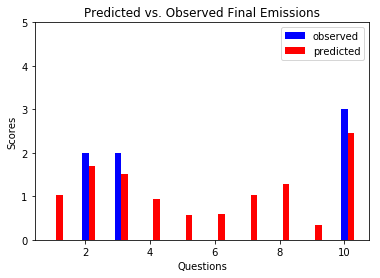

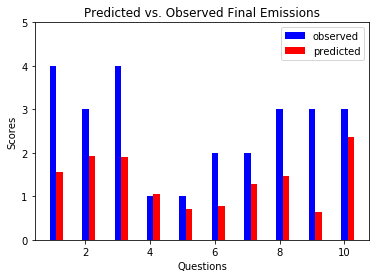

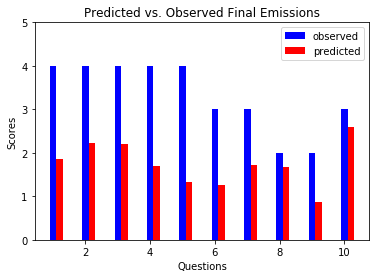

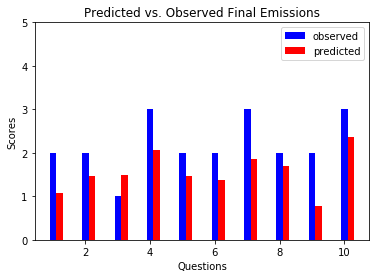

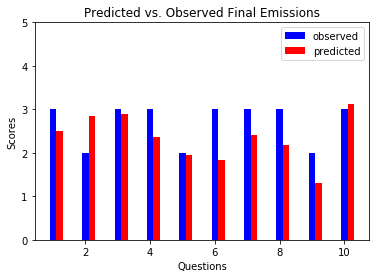

In [14]:
for i in np.random.choice(len(errors), 5):
    plot_bars(i)